In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import nibabel as nib  # NIfTI file reader
import numpy as np
from scipy.ndimage import zoom
import torchio as tio
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score
)
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.models.video as video_models

# ----------------------
# Preprocessing Functions
# ----------------------
def window_image_hu(volume, window_center=40, window_width=80):
    lower = window_center - (window_width / 2)
    upper = window_center + (window_width / 2)
    volume = np.clip(volume, lower, upper)
    volume = (volume - lower) / (upper - lower)
    return volume

def crop_to_brain(volume, margin=5):
    coords = np.nonzero(volume)
    if len(coords[0]) == 0:
        return volume
    zmin, zmax = coords[0].min(), coords[0].max()
    ymin, ymax = coords[1].min(), coords[1].max()
    xmin, xmax = coords[2].min(), coords[2].max()
    return volume[
        max(0, zmin - margin): zmax + margin,
        max(0, ymin - margin): ymax + margin,
        max(0, xmin - margin): xmax + margin
    ]

def resize_or_pad(volume, target_shape=(256, 256, 100)):
    if volume.ndim != 3:
        raise ValueError(f"Input volume must be 3D, but got {volume.ndim}D array with shape {volume.shape}.")
    current_shape = volume.shape
    scales = [t / c for t, c in zip(target_shape, current_shape)]
    if any(s != 1.0 for s in scales):
        volume = zoom(volume, scales, order=1)
    pad_width = [(0, max(0, t - v)) for t, v in zip(target_shape, volume.shape)]
    return np.pad(volume, pad_width, mode="constant", constant_values=0)

# ----------------------
# Dataset Definition
# ----------------------
class NiftiDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_shape=(256, 256, 100)):
        self.samples = []
        self.labels = []
        self.transform = transform
        self.target_shape = target_shape

        valid_labels = {0, 1, 2}
        for class_name in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            try:
                label = int(class_name)
            except ValueError:
                continue
            if label not in valid_labels:
                continue

            for fname in os.listdir(class_dir):
                if not fname.endswith((".nii", ".nii.gz")):
                    continue
                path = os.path.join(class_dir, fname)
                img = nib.load(path).get_fdata()
                img = crop_to_brain(img)
                img = window_image_hu(img)
                img = resize_or_pad(img, target_shape)
                self.samples.append(img)
                self.labels.append(label)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img = self.samples[idx]
        img = (img - img.mean()) / img.std()
        img = np.expand_dims(img, axis=0)  # channel dimension
        tensor = torch.tensor(img, dtype=torch.float32)
        if self.transform:
            tensor = self.transform(tensor)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return tensor, label

# ----------------------
# Pretrained 3D ResNet R3D-18
# ----------------------
def create_pretrained_r3d18(num_classes):
    model = video_models.r3d_18(pretrained=True)
    # Adapt first conv for single-channel input
    model.stem[0] = nn.Conv3d(
        1, 64,
        kernel_size=(3, 7, 7),
        stride=(1, 2, 2),
        padding=(1, 3, 3),
        bias=False
    )
    # Replace final FC
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# ----------------------
# Label Smoothing Loss
# ----------------------
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, logits, target):
        logp = nn.functional.log_softmax(logits, dim=1)
        n = logits.size(1)
        target_onehot = torch.zeros_like(logp).scatter_(1, target.unsqueeze(1), 1)
        smooth = target_onehot * (1 - self.smoothing) + self.smoothing / n
        return (-smooth * logp).sum(dim=1).mean()

# ----------------------
# Training & Cross-Validation
# ----------------------
if __name__ == "__main__":
    dataset_path = "/workspace/TEST/"
    batch_size = 7
    num_epochs = 15
    num_folds = 5
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Data augmentation
    transform = tio.Compose([
        tio.RandomFlip(axes=(0, 1), p=0.5),
        tio.RandomAffine(scales=(0.95, 1.05), degrees=3)
    ])

    # Load data
    dataset = NiftiDataset(dataset_path, transform=transform)
    labels = np.array(dataset.labels)
    print("Unique labels:", set(labels))

    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
        print(f"\n=== Fold {fold+1}/{num_folds} ===")
        train_ds = Subset(dataset, train_idx)
        val_ds = Subset(dataset, val_idx)
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=batch_size)

        model = create_pretrained_r3d18(num_classes=3).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-3)
        criterion = LabelSmoothingCrossEntropy(smoothing=0.1)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5)
        scaler = torch.cuda.amp.GradScaler()

        best_fold_acc = 0.0  # best accuracy for fold
        best_epoch_acc = 0.0  # best accuracy so far in this fold
        history = { 'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [] }

        for epoch in range(num_epochs):
            # Training phase
            model.train()
            running_loss = running_correct = running_total = 0
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                with torch.cuda.amp.autocast():
                    logits = model(x)
                    loss = criterion(logits, y)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                running_loss += loss.item() * y.size(0)
                preds = logits.argmax(dim=1)
                running_correct += (preds == y).sum().item()
                running_total += y.size(0)

            train_loss = running_loss / running_total
            train_acc = running_correct / running_total * 100
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)

            # Validation phase
            model.eval()
            val_loss = val_correct = val_total = 0
            with torch.no_grad():
                for x, y in val_loader:
                    x, y = x.to(device), y.to(device)
                    with torch.cuda.amp.autocast():
                        logits = model(x)
                        loss = criterion(logits, y)
                    val_loss += loss.item() * y.size(0)
                    preds = logits.argmax(dim=1)
                    val_correct += (preds == y).sum().item()
                    val_total += y.size(0)
            val_loss /= val_total
            val_acc = val_correct / val_total * 100
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)

            print(f"Epoch {epoch+1}/{num_epochs}  "
                  f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%  "
                  f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

            scheduler.step(val_acc)

            # Save best model for this fold at each epoch if improved
            if val_acc > best_epoch_acc:
                best_epoch_acc = val_acc
                epoch_best_state = model.state_dict().copy()
                # Save checkpoint for this epoch
                torch.save(epoch_best_state, f"fold_{fold+1}_best_epoch_{epoch+1}.pt")

            # Track best final model for fold
            if val_acc > best_fold_acc:
                best_fold_acc = val_acc
                best_fold_state = model.state_dict().copy()

        # Save the best fold model
        torch.save(best_fold_state, f"fold_{fold+1}_best_model.pt")

        # Final evaluation on validation fold
        all_preds, all_targets = [], []
        model.load_state_dict(best_fold_state)
        model.eval()
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                with torch.cuda.amp.autocast():
                    logits = model(x)
                preds = logits.argmax(dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_targets.extend(y.numpy())

        # Metrics
        f1 = f1_score(all_targets, all_preds, average='weighted')
        acc = accuracy_score(all_targets, all_preds)
        prec = precision_score(all_targets, all_preds, average='weighted')
        rec = recall_score(all_targets, all_preds, average='weighted')
        print(f"Fold {fold+1} => F1: {f1:.4f}, Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}")
        print(classification_report(all_targets, all_preds, target_names=[f"Class {i}" for i in range(3)]))

        # Save fold metrics
        fold_metrics.append({'f1': f1, 'acc': acc, 'prec': prec, 'rec': rec})

        # Plot history
        epochs = range(1, num_epochs+1)
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(epochs, history['train_loss'], label='Train Loss')
        plt.plot(epochs, history['val_loss'], label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f'Fold {fold+1} Loss')

        plt.subplot(1,2,2)
        plt.plot(epochs, history['train_acc'], label='Train Acc')
        plt.plot(epochs, history['val_acc'], label='Val Acc')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.title(f'Fold {fold+1} Accuracy')

        plt.tight_layout()
        plt.savefig(f'fold_{fold+1}_metrics.png')
        plt.close()

        # Confusion Matrix
        cm = confusion_matrix(all_targets, all_preds)
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=[f'Class {i}' for i in range(3)],
                    yticklabels=[f'Class {i}' for i in range(3)])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Fold {fold+1} Confusion Matrix')
        plt.savefig(f'fold_{fold+1}_confusion.png')
        plt.close()

    # Average metrics
    avg = {k: np.mean([m[k] for m in fold_metrics]) for k in fold_metrics[0]}
    print("\n=== Average Metrics Across Folds ===")
    print(f"F1: {avg['f1']:.4f}, Acc: {avg['acc']:.4f}, Prec: {avg['prec']:.4f}, Rec: {avg['rec']:.4f}")


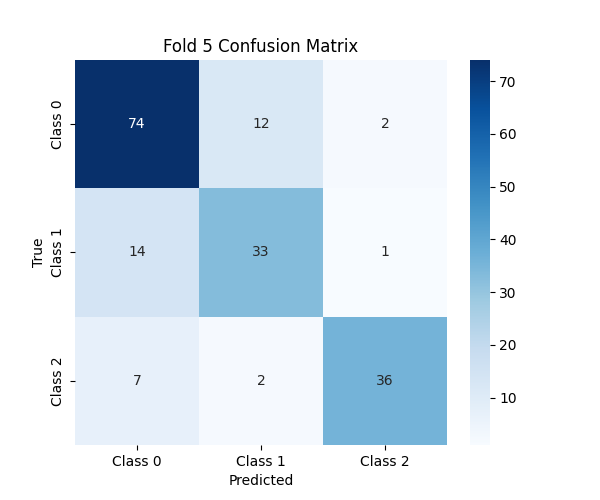

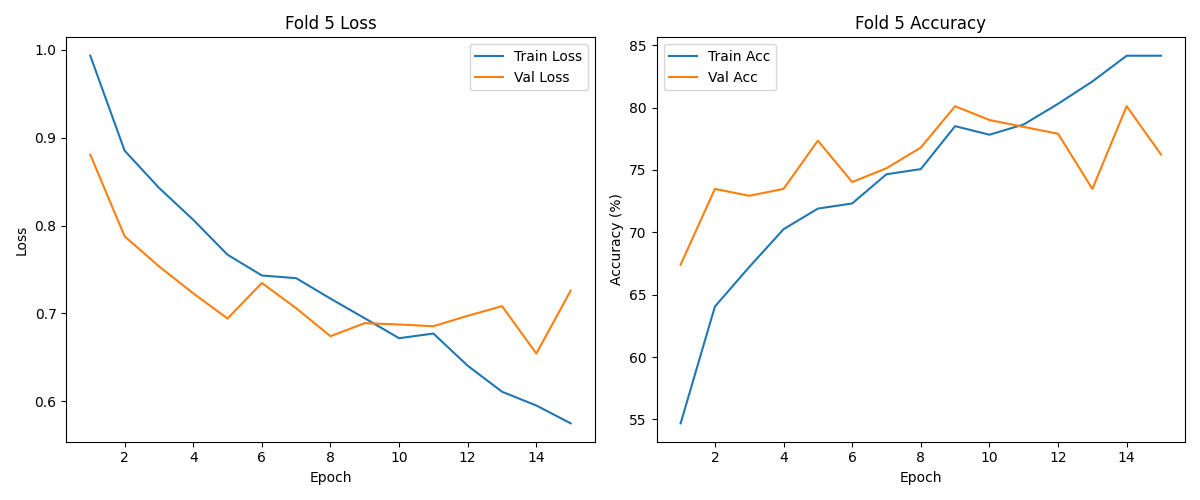